<a href="https://colab.research.google.com/github/iwatanab/boldyreva-encrypted-spatial-overlap/blob/main/Encrypted_Spatial_Overlap_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Problem Overview

*   Project developers need to know whether their claim to an agricultural field is exclusive.
*   Therefore, they need to confident that their fields (represented as geometric polygons), do not overlap with any other developer's claim.
* However, that would require sharing field polygons with competing project developers or some third party assessor.
* Both options potentially violate the landowner's right to privacy.
* Furthermore, as the project generates claimable attributes, purchasers want to be able to trace the attributes back to their source and know that it is based on an exclusive claim.
* This creates a virtually impossible problem of requiring a solution that allows all market participants to evaluate spatial exclusivity but simultaneously keep location data entirely obscured.

## Solution Overview

1.  Polygon coordinates are reduced to a list of 9-digit integers and encrypted with an implementation of [Boldyreva symmetric order-preserving encryption](https://faculty.cc.gatech.edu/~aboldyre/papers/bclo.pdf) scheme. **Order Preserving Encryption (OPE)** preserves the inequality between numbers (greater than, less than, equal to) but not the distance. The strength of this approach is inequalities are binary in nature (is X > Y, results in a True or False). The inability to guage how distant you are from another polygon with your guess protects location against a series of linear "getting warmer" attacks.
2. Encrypted polygons are compressed to less than 255 characters using a technique called [Huffman Encoding](https://web.stanford.edu/class/archive/cs/cs106b/cs106b.1176/assnFiles/assign6/huffman-encoding-supplement.pdf). This size allows the entire polygon to be entered as a single [DNS TXT record](https://www.cloudflare.com/learning/dns/dns-records/dns-txt-record/).
3. Once uploaded to DNS as an 'origin' (along with other attributes such as time range, attribute-type, etc.) any pre-vetted MillPont customer (including auditors) wil be able to assess spatial conflict between polygons.
4. MillPont will operate it's own automated auditign bot that will routinely assess DNS records for spatiotemporal conflict.

Note: This solution in practice will also implement user-side obfuscation which allows the user to send encrypted data to us, which in turns alllows us to re-encypt with our own key without ever decrypting the data sent to us. [Read more](https://www.notion.so/OPE-Nonce-8af828a18fcd4dbfb7b27e8834026972?pvs=4).


# Code Example

## Setup

In [ ]:
!pip install pyope

In [ ]:
from pyope.ope import OPE, ValueRange
import os
from typing import List, Tuple
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

class EncryptedPoint:
    def __init__(self, lat: int, lon: int):
        self.lat = lat
        self.lon = lon

class EncryptedPolygon:
    def __init__(self, points: List[EncryptedPoint]):
        if not 4 <= len(points) <= 10:
            raise ValueError("Polygon must have between 4 and 10 points")
        self.points = points

# Actually use 2 OPEs, one for lat one for lon. Also increased security usign two keys
def setup_ope():
    key = os.urandom(32)  # 256-bit key (32 bytes) 16 for 128 bits
    in_range = ValueRange(0, 360000000)  # Positive-only range
    out_range = ValueRange(0, 2**256 - 1)
    return OPE(key, in_range, out_range)

cipher = setup_ope()

def encrypt_lat(value: float) -> int:
    encrypted_coordinate = cipher.encrypt(int((value+180) * 1000000))
    print(encrypted_coordinate)
    return encrypted_coordinate

def encrypt_lon(value: float) -> int:
    encrypted_coordinate = cipher.encrypt(int((value+90) * 1000000))
    print(encrypted_coordinate)
    return encrypted_coordinate

def compare_encrypted_values(a: int, b: int) -> int:
    if a < b:
        return -1
    elif a > b:
        return 1
    return 0

def is_point_inside_polygon(point: EncryptedPoint, polygon: EncryptedPolygon) -> bool:
    inside = False
    for i in range(len(polygon.points)):
        p1 = polygon.points[i]
        p2 = polygon.points[(i + 1) % len(polygon.points)]
        if (((compare_encrypted_values(p1.lon, point.lon) > 0) != (compare_encrypted_values(p2.lon, point.lon) > 0)) and
            (compare_encrypted_values(point.lat, p1.lat) > 0) and
            (compare_encrypted_values(point.lat, p2.lat) > 0)):
            inside = not inside
    return inside

def do_polygons_overlap(poly1: EncryptedPolygon, poly2: EncryptedPolygon) -> bool:
    # Check if any point of poly1 is inside poly2
    for point in poly1.points:
        if is_point_inside_polygon(point, poly2):
            return True

    # Check if any point of poly2 is inside poly1
    for point in poly2.points:
        if is_point_inside_polygon(point, poly1):
            return True

    # Check if edges intersect
    for i in range(len(poly1.points)):
        for j in range(len(poly2.points)):
            if do_segments_intersect(poly1.points[i], poly1.points[(i+1)%len(poly1.points)],
                                     poly2.points[j], poly2.points[(j+1)%len(poly2.points)]):
                return True

    return False

def do_segments_intersect(p1: EncryptedPoint, p2: EncryptedPoint,
                          p3: EncryptedPoint, p4: EncryptedPoint) -> bool:
    o1 = orientation(p1, p2, p3)
    o2 = orientation(p1, p2, p4)
    o3 = orientation(p3, p4, p1)
    o4 = orientation(p3, p4, p2)

    return (o1 != o2) and (o3 != o4)

def orientation(p: EncryptedPoint, q: EncryptedPoint, r: EncryptedPoint) -> int:
    # We can't subtract, so we'll use a series of comparisons
    if compare_encrypted_values(q.lon, p.lon) >= 0:
        if compare_encrypted_values(r.lat, q.lat) >= 0:
            if compare_encrypted_values(q.lat, p.lat) >= 0:
                return 1
            else:
                return -1
        else:
            if compare_encrypted_values(q.lat, p.lat) < 0:
                return 1
            else:
                return -1
    else:
        if compare_encrypted_values(r.lat, q.lat) >= 0:
            if compare_encrypted_values(q.lat, p.lat) < 0:
                return -1
            else:
                return 1
        else:
            if compare_encrypted_values(q.lat, p.lat) >= 0:
                return -1
            else:
                return 1

def create_encrypted_polygon(coordinates: List[Tuple[float, float]]) -> EncryptedPolygon:
    return EncryptedPolygon([EncryptedPoint(encrypt_lat(lat), encrypt_lon(lon))
                             for lat, lon in coordinates])



## Testing Encrypted Overlap Detection

26912269226203825641383339655740505168403096837241673209221443376678593286436
43456345959174132642656285629749097970298830427830937142641372612048184921078
26912269226203825641383339655740505168403096837241673209221443376678593286436
43456475029602126437677306313379512518972801596207759986348484895862283372716
26912426885658829751724862713164796964920443512348145053123479403331563906676
43456475029602126437677306313379512518972801596207759986348484895862283372716
26912426885658829751724862713164796964920443512348145053123479403331563906676
43456345959174132642656285629749097970298830427830937142641372612048184921078
26912335126778269672652736248759188204147100188440699768766295761810787596214
43456394806758889658377515482129510369798190300266360525541286796576881661237
26912335126778269672652736248759188204147100188440699768766295761810787596214
43456521022113772764866952868429700210839778974680642422279972232389603675031
2691251960386449992530215599007238491615970812463293189677997160

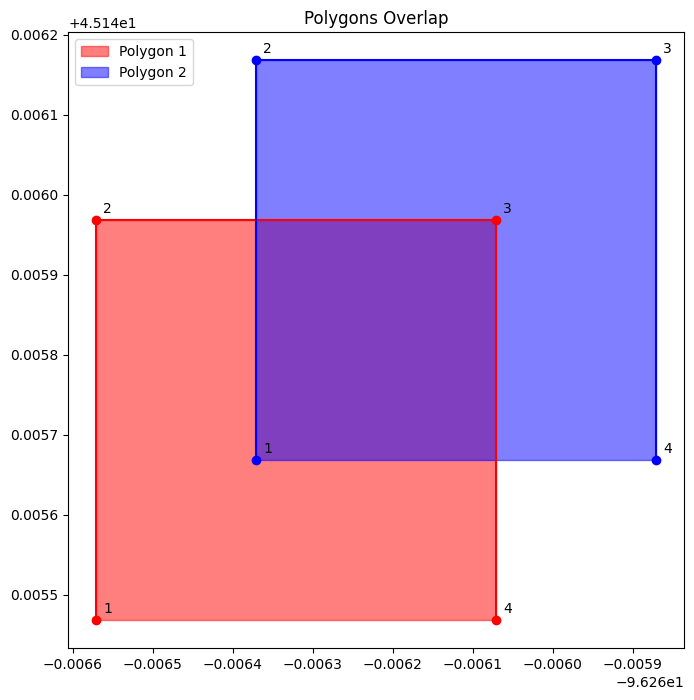

61150454290808754389748047721865520615022753389709384083608587384151178882027
43655835870046383887400778387840613451062195102970571699863508267704529845572
61150454290808754389748047721865520615022753389709384083608587384151178882027
43656001553096382125829832919862581060754184023844156758564034890350061306010
61150327246319940661590649808889402927811514330199234799651040279777439630100
43656001553096382125829832919862581060754184023844156758564034890350061306010
61150327246319940661590649808889402927811514330199234799651040279777439630100
43655835870046383887400778387840613451062195102970571699863508267704529845572
64609688956615362678698940745840185395039253323157759198637816447262984612780
46668631880107652016592675139659977703529051887614387130591184850646929892575
64609688956615362678698940745840185395039253323157759198637816447262984612780
46668779196302248826801091092545391807804542165875415659903492395792953282519
6460955326393072151599171823871808514593078505858378716745967541

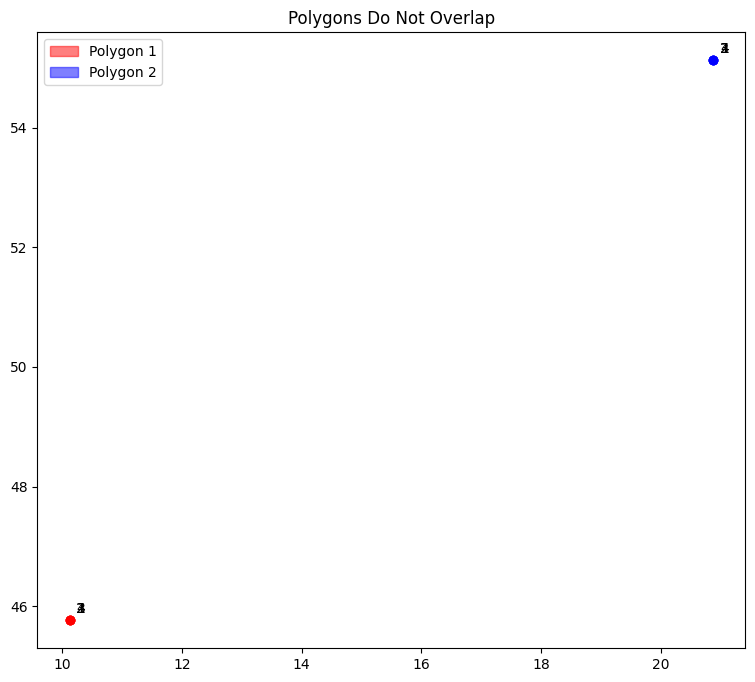

67862532464923981330324384528427203624479080971315250758158786631646583429833
28887308011687208029154325784991341946288126243707618189101045003207964507123
67862532464923981330324384528427203624479080971315250758158786631646583429833
28887388868296058656720477757539825185496990256246472304184531979326851858457
67862372391635198187087903834443926849920262508463851966883853579001256408576
28887388868296058656720477757539825185496990256246472304184531979326851858457
67862372391635198187087903834443926849920262508463851966883853579001256408576
28887308011687208029154325784991341946288126243707618189101045003207964507123
67862431436343035903259535433706026942366620950245523996163271159088811379252
28887370797824411432474279336882683294965877421797617291464412320408264863784
67862431436343035903259535433706026942366620950245523996163271159088811379252
28887407291428487400913083561619997351980286132699713425564987974137064104661
6786239533964842442973892634401436346057648405066505556682004800

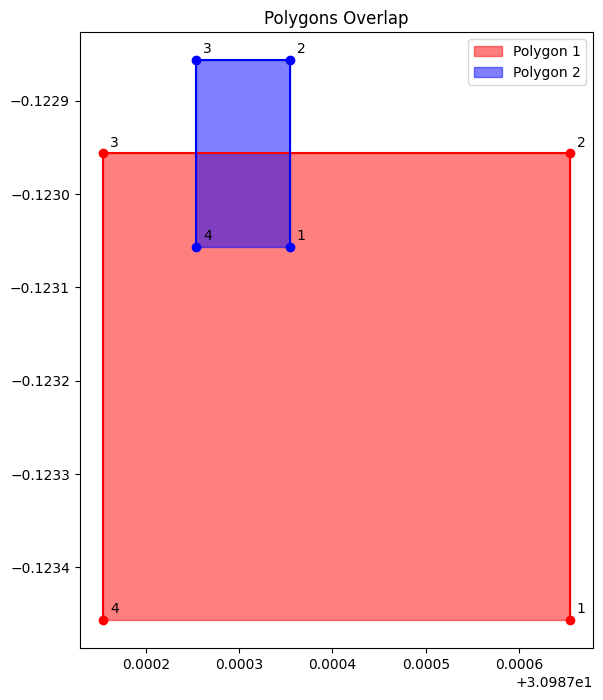

70794087756822881946255739442786609695767816956567981439516756009278635567275
35432314542173419120632817306699070819515477717774838455056996118402169547382
70794087756822881946255739442786609695767816956567981439516756009278635567275
35432511650425207946620375990438467350716787364875547557149501553633341563049
70793937610884509570476604353760053038365987314346334918674470567670437635760
35432511650425207946620375990438467350716787364875547557149501553633341563049
70793937610884509570476604353760053038365987314346334918674470567670437635760
35432314542173419120632817306699070819515477717774838455056996118402169547382
70793937610884509570476604353760053038365987314346334918674470567670437635760
35432511650425207946620375990438467350716787364875547557149501553633341563049
70793937610884509570476604353760053038365987314346334918674470567670437635760
35432634346678171306098697922176931304627568257012900293875754213339331212783
7079375633443691223150933569342683237302340745176238966058366469

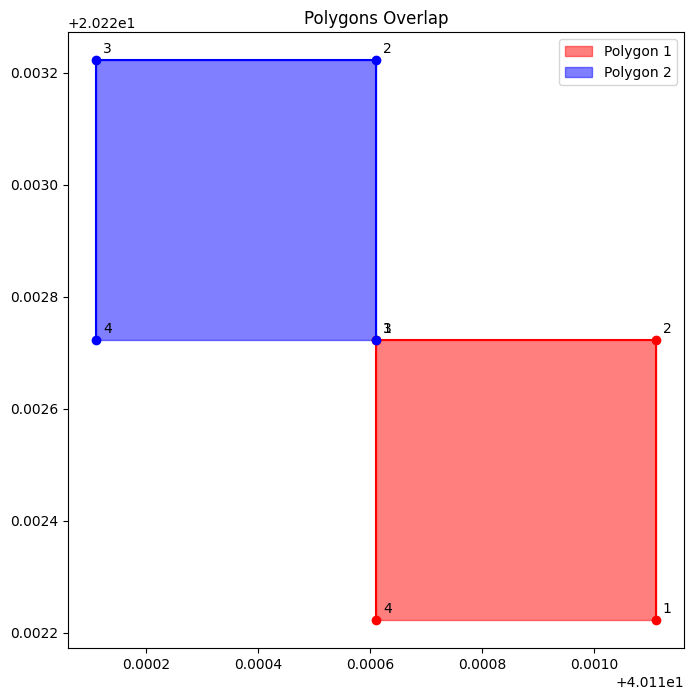

74158330384873662897653262704720361391395386832960217268904082963272322780154
38721287186617045120957397207897442618038492346079216091854686958416428995434
74158374493654078718800424735007706434995220711910099390162133210184286191244
38721471719095887304428274502852743888859048859973171273727817429751730411712
74158354923960249340786244879274047287998561790339683928926407222021682867307
38721671659594532556648415359058085958113013994861411737759306943048606518598
74158297429294899933733795638266428047646312506422789338869097858132557947139
38721704453498087732985599826119383341322857108008800543184654329029035056905
74158242258861397904333552323685557820610673056068951961977035566490501899219
38721579390789792002761260420249133347688311669767016018325531630928786642111
74158213914425280376420333802637078446474762878666057476460383395107638127811
38721503956008751682142166299144870236874741189027215457863543961649579147916
7415818032661071746665411911013512439288845451347747783503226449

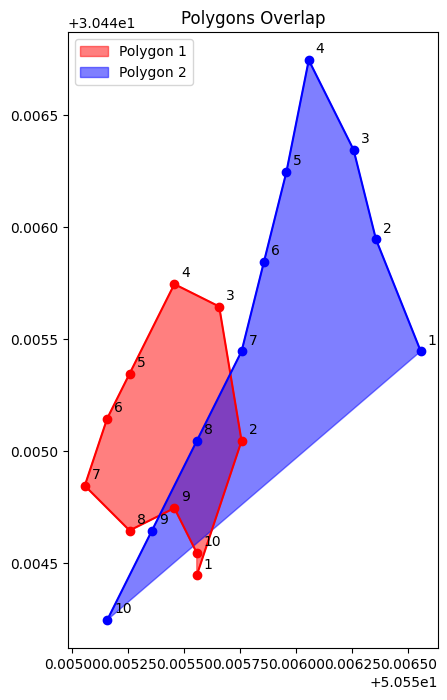

In [ ]:
# Simple function for visualizing polygons
def visualize_polygons(polygons: List[List[Tuple[float, float]]], labels: List[str], overlap: bool):
    fig, ax = plt.subplots(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'orange', 'purple']

    for i, poly in enumerate(polygons):
        patch = MplPolygon(poly, alpha=0.5, color=colors[i % len(colors)], label=labels[i])
        ax.add_patch(patch)

        # Plot points and number them
        xs, ys = zip(*poly)
        ax.plot(xs, ys, 'o-', color=colors[i % len(colors)])
        for j, (x, y) in enumerate(poly):
            ax.annotate(str(j+1), (x, y), xytext=(5, 5), textcoords='offset points')

    ax.autoscale()
    ax.set_aspect('equal', 'box')
    ax.legend()
    ax.set_title(f"Polygons {'Overlap' if overlap else 'Do Not Overlap'}")
    plt.show()

# Example usage with different scenarios
scenarios = [
    # Scenario 1: Overlapping polygons representing agricultural fields
    ([(-96.2665708, 45.1454682), (-96.2665708, 45.1459682),
      (-96.2660708, 45.1459682), (-96.2660708, 45.1454682)],

     [(-96.2663708, 45.1456682), (-96.2663708, 45.1461682),
      (-96.2658708, 45.1461682), (-96.2658708, 45.1456682)]),

    # Scenario 2: Non-overlapping polygons in different fields
    ([(10.1234567, 45.7654321), (10.1234567, 45.7659321),
      (10.1229567, 45.7659321), (10.1229567, 45.7654321)],

     [(20.8765432, 55.1234567), (20.8765432, 55.1239567),
      (20.8760432, 55.1239567), (20.8760432, 55.1234567)]),

    # Scenario 3: One polygon inside another, representing nested fields
    ([(30.9876543, -0.1234567), (30.9876543, -0.1229567),
      (30.9871543, -0.1229567), (30.9871543, -0.1234567)],

     [(30.9873543, -0.1230567), (30.9873543, -0.1228567),
      (30.9872543, -0.1228567), (30.9872543, -0.1230567)]),

    # Scenario 4: Polygons touching at a point, representing adjacent fields
    ([(40.1111111, 20.2222222), (40.1111111, 20.2227222),
      (40.1106111, 20.2227222), (40.1106111, 20.2222222)],

     [(40.1106111, 20.2227222), (40.1106111, 20.2232222),
      (40.1101111, 20.2232222), (40.1101111, 20.2227222)]),

    # Scenario 5: Complex polygons with slight overlap, representing irregularly shaped fields
    ([(50.5555555, 30.4444444), (50.5557555, 30.4450444),
      (50.5556555, 30.4456444), (50.5554555, 30.4457444),
      (50.5552555, 30.4453444), (50.5551555, 30.4451444),
      (50.5550555, 30.4448444), (50.5552555, 30.4446444),
      (50.5554555, 30.4447444), (50.5555555, 30.4445444)],

     [(50.5565555, 30.4454444), (50.5563555, 30.4459444),
      (50.5562555, 30.4463444), (50.5560555, 30.4467444),
      (50.5559555, 30.4462444), (50.5558555, 30.4458444),
      (50.5557555, 30.4454444), (50.5555555, 30.4450444),
      (50.5553555, 30.4446444), (50.5551555, 30.4442444)])
]

for i, (poly1_coords, poly2_coords) in enumerate(scenarios, 1):
    poly1 = create_encrypted_polygon(poly1_coords)
    poly2 = create_encrypted_polygon(poly2_coords)
    print(f"Encrypted Polygon 1: {poly1.points}")
    print(f"Encrypted Polygon 2: {poly2.points}")

    overlap = do_polygons_overlap(poly1, poly2)
    print(f"Scenario {i}: Polygons overlap: {overlap}")

    visualize_polygons([poly1_coords, poly2_coords], ['Polygon 1', 'Polygon 2'], overlap)

# Huffman Compression

In [ ]:
test_encrypted_polygon = [
    74154643089820618900438041622207346158289297314720532505721750928072770677739,
    38738396533150640684760343496241595693857293224317896556092920819030630724324,
    74154688058353537011973479180992870578871365054358467569761950525398235469072,
    38738564845919070143361185334426372967957777712101668444093998011416290340795,
    74154664310854877714104337929713226467763845853088202832098862887909512832590,
    38738792007470188310334002675522280616052648610536607310101549895821858636178,
    74154620760123492419972125913524984260134268935964073402739594015405897504809,
    38738821225733528516048260364736016380227869420157634926191819984282469315525,
    74154556792912143459105981512442138729629973785425533607262654711759865845513,
    38738682620273134197795104301208614498965123461489730082318161219373779084518,
    74154526931542761582538806610447731624758848479980095076685427798969441678638,
    38738599014654841129332598837470901947982737188557810109839806031977674681593,
    74154504237210268375646217001436836815086966923939204762094816986051326449436,
    38738511208760779516742430789585982299594209649106745019670072367108458755351,
    74154556792912143459105981512442138729629973785425533607262654711759865845513,
    38738453216124335328478380698052284066433943741113158895524799484775603085091,
    74154620760123492419972125913524984260134268935964073402739594015405897504809,
    38738484837882618300774410144250677011461567656591258770442728949060464010706,
    74154643089820618900438041622207346158289297314720532505721750928072770677739,
    38738425105043615263984645113539250404747192156717300559963880323822904233389
]


In [ ]:
import random
from typing import List, Tuple
from collections import Counter

# Generate random integers of specific length (39 digits)
def generate_random_integers(length: int, count: int = 44) -> List[int]:
    return [random.randint(10**(length-1), 10**length - 1) for _ in range(count)]

# Function to perform delta encoding
def delta_encode(integers: List[int]) -> List[int]:
    if not integers:
        return []
    deltas = [integers[0]]
    for i in range(1, len(integers)):
        deltas.append(integers[i] - integers[i - 1])
    return deltas

# Huffman Coding Functions
def build_huffman_code(deltas: List[int]) -> dict:
    freqs = Counter(deltas)
    heap = [[weight, [symbol, ""]] for symbol, weight in freqs.items()]
    while len(heap) > 1:
        lo = min(heap, key=lambda x: x[0])
        heap.remove(lo)
        hi = min(heap, key=lambda x: x[0])
        heap.remove(hi)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heap.append([lo[0] + hi[0]] + lo[1:] + hi[1:])  # Correcting the syntax issue
    huffman_code = dict(heap[0][1:])
    return huffman_code

def huffman_encode(deltas: List[int]) -> str:
    huffman_code = build_huffman_code(deltas)
    encoded = ''.join(huffman_code[delta] for delta in deltas)
    return encoded

def huffman_decode_and_reconstruct(encoded: str, huffman_code: dict) -> List[int]:
    reverse_huffman_code = {v: k for k, v in huffman_code.items()}
    decoded_deltas = []
    buffer = ''
    for bit in encoded:
        buffer += bit
        if buffer in reverse_huffman_code:
            decoded_deltas.append(reverse_huffman_code[buffer])
            buffer = ''
    if decoded_deltas:
        original = [decoded_deltas[0]]
        for i in range(1, len(decoded_deltas)):
            original.append(original[-1] + decoded_deltas[i])
    else:
        original = []
    return original

# Function to verify lossless compression by comparing original and decompressed values
def verify_lossless_correct(original: List[int], decoded: List[int]) -> bool:
    return original == decoded

# Function to test Huffman compression method with proof of equivalence
def test_huffman_compression_proof(num_tests: int, integer_length: int) -> None:
    for test_index in range(num_tests):
        # Generate random integers and delta encode them
        original_list = test_encrypted_polygon
        delta_encoded = delta_encode(original_list)

        # Encode using Huffman coding
        huffman_encoded = huffman_encode(delta_encoded)
        huffman_code = build_huffman_code(delta_encoded)

        # Decode the encoded data and reconstruct the original list
        decoded_original = huffman_decode_and_reconstruct(huffman_encoded, huffman_code)

        # Verify losslessness
        is_huffman_lossless = verify_lossless_correct(original_list, decoded_original)

        # Calculate original and compressed lengths
        original_length = sum(len(str(num)) for num in original_list)
        compressed_huff_len = len(huffman_encoded)

        # Output the results
        print(f"Test {test_index + 1}:")
        print(f"  Original List: {original_list}")
        print(f"  Original Character Length: {original_length}")
        print(f"  Huffman Encoded Value: {huffman_encoded}")
        print(f"  Huffman Encoding Length: {compressed_huff_len}")
        print(f"  Decoded List: {decoded_original}")
        print(f"  Huffman Lossless: {is_huffman_lossless}")
        print(f"  Lists are equivalent: {original_list == decoded_original}")
        print()

# Run the test with 30 lists of randomly generated integers (39 digits each)
test_huffman_compression_proof(1, 77)


Test 1:
  Original List: [74154643089820618900438041622207346158289297314720532505721750928072770677739, 38738396533150640684760343496241595693857293224317896556092920819030630724324, 74154688058353537011973479180992870578871365054358467569761950525398235469072, 38738564845919070143361185334426372967957777712101668444093998011416290340795, 74154664310854877714104337929713226467763845853088202832098862887909512832590, 38738792007470188310334002675522280616052648610536607310101549895821858636178, 74154620760123492419972125913524984260134268935964073402739594015405897504809, 38738821225733528516048260364736016380227869420157634926191819984282469315525, 74154556792912143459105981512442138729629973785425533607262654711759865845513, 38738682620273134197795104301208614498965123461489730082318161219373779084518, 74154526931542761582538806610447731624758848479980095076685427798969441678638, 38738599014654841129332598837470901947982737188557810109839806031977674681593, 74154504237210268375646217